# only run this if you need to install any of those packages
import sys
!conda install --yes --prefix {sys.prefix} tifffile
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} scipy
!conda install --yes --prefix {sys.prefix} pymongo


## Import all necessary dependencies

In [1]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from tifffile import imread
from PIL import Image,ImageOps, ImageEnhance, ImagePalette
from scipy.ndimage import rotate
import json

## Tutorial preparation: Create both examples
The first one is a simple 4x4 matrix flipped around.
The second one is a more complex example with 8 images

In [2]:
# setting up the  images for the first example
a = np.zeros((4,4), np.int32)
a[:2] = 1
example1_images = []
example1_images.append(a)
b = a.copy()
b[:2] =2
example1_images.append(np.flip(b.transpose()))
c = a.copy()
c[:2] =3
example1_images.append(np.flip(c))
d = a.copy()
d[:2] =4
example1_images.append(d.transpose())

In [3]:
display(example1_images)

[array([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]),
 array([[0, 0, 2, 2],
        [0, 0, 2, 2],
        [0, 0, 2, 2],
        [0, 0, 2, 2]]),
 array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [3, 3, 3, 3],
        [3, 3, 3, 3]]),
 array([[4, 4, 0, 0],
        [4, 4, 0, 0],
        [4, 4, 0, 0],
        [4, 4, 0, 0]])]

In [3]:
# setting up the images for second example
example2_images = []
example2_images.append(np.invert(imread("up_big.tif")))
example2_images[0][example2_images[0]>0] = 130
example2_images.append(rotate(np.transpose(np.flip(example2_images[0]).copy()), angle=45, reshape=False, mode="constant", cval=0))
example2_images[1][example2_images[1]>0] = 131
example2_images.append(np.transpose(np.flip(example2_images[0]).copy()))
example2_images[2][example2_images[2]>0] = 132
example2_images.append(rotate(np.flip(example2_images[0]).copy(), angle=45, reshape=False, mode="constant", cval=0))
example2_images[3][example2_images[3]>0] = 133
example2_images.append(np.flip(example2_images[0]).copy())
example2_images[4][example2_images[4]>0] = 134
example2_images.append(rotate(np.transpose(example2_images[0]).copy(), angle=45, reshape=False, mode="constant", cval=0))
example2_images[5][example2_images[5]>0] = 135
example2_images.append(np.transpose(example2_images[0]).copy())
example2_images[6][example2_images[6]>0] = 136
example2_images.append(rotate(example2_images[0], angle=45, reshape=False, mode="constant", cval=0))
example2_images[7][example2_images[7]>0] = 137

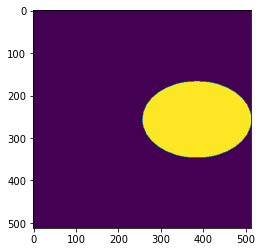

In [5]:
import matplotlib.pyplot as plt
plt.imshow(example2_images[2])

# Important part starts here


## Example 1a: Iterate over all images, simple 4x4 matrix
All images must have the same shape and the ids used must be unique, otherwise it is possible that wrong fragments are created.

In [6]:
import Labeling as lb

merger = lb.Labeling.fromValues(np.zeros((4, 4), np.int8))
merger.iterate_over_images(example1_images, list(range(1,len(example1_images)+1)))
img, labeling = merger.save_result("example1")

In [7]:
display(list(range(1,len(example1_images)+1)))
display(example1_images[0])

display(img)
display(vars(labeling))

[1, 2, 3, 4]

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

array([[6, 6, 3, 3],
       [6, 6, 3, 3],
       [7, 7, 4, 4],
       [7, 7, 4, 4]], dtype=int8)

{'version': 1,
 'numSets': 5,
 'indexImg': 'example1.tif',
 'labelMapping': {},
 'labelSets': {'0': [], '1': [3, 6], '2': [3, 4], '3': [4, 7], '4': [6, 7]},
 'segmentationSource': {'1': ['1'], '2': ['2'], '3': ['3'], '4': ['4']}}

In [8]:
import Labeling2 as lb

merger = lb.Labeling2.fromValues(np.zeros((4, 4), np.int8))
merger.iterate_over_images(example1_images, list(range(1,len(example1_images)+1)))
img, labeling = merger.save_result("example1")
display(list(range(1,len(example1_images)+1)))
display(example1_images[0])

display(img)
display(vars(labeling))

[1, 2, 3, 4]

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

array([[6, 6, 3, 3],
       [6, 6, 3, 3],
       [7, 7, 4, 4],
       [7, 7, 4, 4]], dtype=int8)

{'version': 1,
 'numSets': 5,
 'indexImg': 'example1.tif',
 'labelMapping': {},
 'labelSets': {'0': {'source': '', 'set': []},
  '1': {'source': 1, 'set': [3, 6]},
  '2': {'source': 2, 'set': [3, 4]},
  '3': {'source': 3, 'set': [4, 7]},
  '4': {'source': 4, 'set': [6, 7]}},
 'segmentationSource': None}

## Example 1b: Add patches to the result, here iteration over sliced images
A patch is a n by m pixel sized subimage which can be added at any place (described by x,y params) in the result, 
but the whole patch must be inside the result image.
Constraints:
n+x <= width of image
m+y <= height of image
Important code points are marked with a comment

In [ ]:
# Initialize the merger with the first image. This can also be an empty image of zeros in the correct shape
merger = lb.Labeling.fromValues(first_image=example1_images[0])
patch_size = 2
for image in example1_images[1:]:
    #start position
    x, y = 0, 0
    #create 2x2 patches from each image
    patches = np.vsplit(image, int(image.shape[0] / patch_size))
    patches = [np.hsplit(seg, int(image.shape[1] / patch_size)) for seg in patches]
    for patchList in patches:
        for patch in patchList:
            # add a patch at the defined spot
            merger.add_segments(patch, (x, y))
            y += patch_size
        y = 0
        
        x += patch_size
labeling = merger.save_result("example1")
#add_anything(data, (x,y,z):Tuple, merge:dict=None)
# returns dict of actual labels dif

In [ ]:
display(example1_images[0])
display(img)
display(vars(labeling))

### Notice: the two methods do NOT create the same result in terms of values in the image, but the sets are the still the same

## Example 2a: Iterate over all images, more complex

In [9]:
merger = lb.Labeling2.fromValues()
display(merger.list_of_unique_ids)
merger.iterate_over_images(example2_images, list(range(1,len(example2_images)+1)))
display(merger.list_of_unique_ids)
img, labeling2 = merger.save_result("example2")

[0]

[0, 130, 131, 132, 133, 134, 135, 136, 137]

In [10]:
display(ImageOps.equalize(ImageOps.autocontrast(Image.fromarray(img), ignore=0)))


OSError: not supported for this image mode

In [11]:
display(vars(labeling2))

{'version': 1,
 'numSets': 9,
 'indexImg': 'example2.tif',
 'labelMapping': {},
 'labelSets': {'0': {'source': '', 'set': []},
  '1': {'source': 1,
   'set': [1, 3, 4, 7, 9, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55]},
  '2': {'source': 2,
   'set': [2,
    3,
    4,
    5,
    7,
    8,
    9,
    17,
    22,
    24,
    28,
    29,
    44,
    47,
    48,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    59,
    60,
    63]},
  '3': {'source': 3,
   'set': [4, 5, 6, 7, 8, 12, 16, 17, 48, 52, 24, 59, 60, 29, 30]},
  '4': {'source': 4,
   'set': [7,
    8,
    9,
    11,
    12,
    13,
    16,
    17,
    24,
    26,
    28,
    29,
    30,
    40,
    52,
    54,
    55,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    65]},
  '5': {'source': 5,
   'set': [64, 65, 66, 40, 41, 13, 14, 16, 17, 30, 26, 27, 28, 29, 62, 63]},
  '6': {'source': 6,
   'set': [18,
    22,
    24,
    26,
    27,
    28,
    29,
    30,
    34,
    40,
    41,
    49,
    50,
    51,
   

## Example 2b: Add patches to the result, here iteration over sliced images
A patch is a n by m pixel sized subimage which can be added at any place (described by x,y params) in the result, 
but the whole patch must be inside the result image.
The size of the patch is not important and may depend on your algorithm to create the patches. There is also no need for it to be quadratic.
Constraints:
n+x <= width of image
m+y <= height of image

In [ ]:
merger = msm.MetaSegmentMerger.fromValues(first_image=example2_images[0])
patch_size = 64 
for image in example2_images[1:]:
    #start position
    x, y = 0, 0
    #create 64x64 patches from each image
    patches = np.vsplit(image, int(image.shape[0] / patch_size))
    patches = [np.hsplit(seg, int(image.shape[1] / patch_size)) for seg in patches]
    for patchList in patches:
        for patch in patchList:
            merger.add_segments(patch, x, y)
            y += patch_size
        y = 0
        x += patch_size
labeling = merger.save_result("example2")

In [ ]:
display(ImageOps.equalize(ImageOps.autocontrast(Image.fromarray(labeling.img), ignore=0)))
display(vars(labeling.labels))

## Example 3: Loading data from file
The image is expected to be in the same folder as the .bson-File by default.
The examples above provide just that.

In [ ]:
loaded_labeling = bc.Labeling.from_file('example1.bson')
display(loaded_labeling.img)
display(vars(loaded_labeling.labels))